In [ ]:
# Import Libraries

import torch
import numpy as np
from torch import nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, AvgPool2d, Softmax, BatchNorm2d, Dropout
from torch.optim import SGD
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
## Data Preparation and Preprocessing

# From CIFAR-10 Documentation
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

# Retrieve all batches
data_batch_1 = unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_5')
test_batch = unpickle('/content/drive/MyDrive/cifar-10-batches-py/test_batch')

# Get data batches from each dictionaries
train_data_1 = data_batch_1['data'].reshape(10000,3,32,32)
train_data_2 = data_batch_2['data'].reshape(10000,3,32,32)
train_data_3 = data_batch_3['data'].reshape(10000,3,32,32)
train_data_4 = data_batch_4['data'].reshape(10000,3,32,32)
train_data_5 = data_batch_5['data'].reshape(10000,3,32,32)
test_data = test_batch['data'].reshape(10000,3,32,32)

# Get label batches from each dictionaries
y1 = data_batch_1['labels']
y2 = data_batch_2['labels']
y3 = data_batch_3['labels']
y4 = data_batch_4['labels']
y5 = data_batch_5['labels']
y_test = test_batch['labels']

# Combine all training data
train_data = np.concatenate((train_data_1, train_data_2, train_data_3, train_data_4, train_data_5), axis = 0)
y_train = np.concatenate((y1, y2, y3, y4, y5), axis = 0)

# Divide pixel values by 255
train_data = train_data/255
test_data = test_data/255

# Crop from the center (3x32x32 -> 3x28x28)
dummy_train = np.delete(train_data, (0,1,30,31), 2)
dummy_test = np.delete(test_data, (0,1,30,31), 2)
cropped_train_data = np.delete(dummy_train, (0,1,30,31), 3)
cropped_test_data = np.delete(dummy_test, (0,1,30,31), 3)

# Data normalization per image of train and test dataset
mean_train = np.zeros(50000)
mean_test = np.zeros(10000)
std_train = np.zeros(50000)
std_test = np.zeros(10000)
final_train_data = np.zeros((50000,3,28,28))
final_test_data = np.zeros((10000,3,28,28))

for i in range(0, 50000):
    mean_train[i] = np.mean(cropped_train_data[i])
    std_train[i] = np.std(cropped_train_data[i])
    final_train_data[i,:,:,:] = (cropped_train_data[i,:,:,:] - mean_train[i])/std_train[i]

for i in range(0, 10000):
    mean_test[i] = np.mean(cropped_test_data[i])
    std_test[i] = np.std(cropped_test_data[i])
    final_test_data[i,:,:,:] = (cropped_test_data[i,:,:,:] - mean_test[i])/std_test[i]

# Prepare torch-ready training dataset
train_x = torch.from_numpy(np.float32(final_train_data))
train_y = y_train.astype(np.float32)
train_y = torch.from_numpy(train_y)

# Prepare torch-ready testing dataset
test_x = torch.from_numpy(np.float32(final_test_data))
test_x = test_x.to(DEVICE)
test_y = np.array(y_test).astype(np.float32)
test_y = torch.from_numpy(test_y)
test_y = test_y.to(DEVICE)

# Delete variables not in used
del data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch, train_data_1, train_data_2, train_data_3, train_data_4, train_data_5, test_data
del y1, y2, y3, y4, y5, train_data, dummy_train, dummy_test, cropped_train_data, cropped_test_data, mean_train, mean_test, std_train, std_test

In [ ]:
## Inception Model Creation

# For convolutional module
class ConvBlock(nn.Module):
    def __init__(self, cin, cout, filt_size, strd, pad):
        super(ConvBlock, self).__init__()
        self.conv2d = Conv2d(in_channels=cin, out_channels=cout, kernel_size=filt_size, stride=strd, padding=pad)
        self.batch_norm = BatchNorm2d(num_features=cout)
        self.relu = ReLU()
    def forward(self, x):
        return self.relu(self.batch_norm(self.conv2d(x)))

# For inception module
class InceptionBlock(nn.Module):
    def __init__(self, cin, cout1, cout3):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBlock(cin, cout1, filt_size=1, strd=1, pad=0)
        self.branch2 = ConvBlock(cin, cout3, filt_size=3, strd=1, pad=1)
    def forward(self, x):
        branches = (self.branch1, self.branch2)
        return torch.cat([branch(x) for branch in branches], 1)

# For downsample module
class DownsampleBlock(nn.Module):
    def __init__(self, cin, cout3):
        super(DownsampleBlock, self).__init__()
        self.branch1 = ConvBlock(cin, cout3, filt_size=3, strd=2, pad=0)
        self.branch2 = MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):
        branches = (self.branch1, self.branch2)
        return torch.cat([branch(x) for branch in branches], 1)

# For the whole small model
class small_inception(nn.Module):
    def __init__(self, num_classes=10):
        super(small_inception, self).__init__()
        self.conv1 = ConvBlock(cin=3, cout=96, filt_size=3, strd=1, pad=0)
        self.inception1a = InceptionBlock(cin=96, cout1=32, cout3=32)
        self.inception1b = InceptionBlock(cin=64, cout1=32, cout3=48)
        self.downsample1 = DownsampleBlock(cin=80, cout3=80)
        self.inception2a = InceptionBlock(cin=160, cout1=112, cout3=48)
        self.inception2b = InceptionBlock(cin=160, cout1=96, cout3=64)
        self.inception2c = InceptionBlock(cin=160, cout1=80, cout3=80)
        self.inception2d = InceptionBlock(cin=160, cout1=48, cout3=96)
        self.downsample2 = DownsampleBlock(cin=144, cout3=96)
        self.inception3a = InceptionBlock(cin=240, cout1=176, cout3=160)
        self.inception3b = InceptionBlock(cin=336, cout1=176, cout3=160)
        self.avgpool = AvgPool2d(kernel_size=7, padding = 1)
        self.fully_connected = Linear(336, num_classes)
        self.dropout = Dropout(0.9)
        self.fully_relu = ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1a(x)
        x = self.inception1b(x)
        x = self.downsample1(x)
        x = self.inception2a(x)
        x = self.inception2b(x)
        x = self.inception2c(x)
        x = self.inception2d(x)
        x = self.downsample2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fully_connected(x)
        x = self.dropout(x)
        x = self.fully_relu(x)
        return x

In [ ]:
from os import access
## for training purposes

model = small_inception()
model = model.to(DEVICE)
optimizer = SGD(model.parameters(), lr=0.01)
loss = CrossEntropyLoss()

batch_size = 16
epochs = 80

train_loss = []
accuracy = []

for epoch in range(epochs):
    loss_train = 0
    model.train()
    for i in range(0, train_x.shape[0], batch_size):
        batch_x = train_x[i:i+batch_size,:,:,:]
        batch_y = train_y[i:i+batch_size]
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        optimizer.zero_grad()
        output_x = model(batch_x)
        loss_x = loss(output_x, batch_y.long())
        loss_train += loss_x
        loss_x.backward()
        optimizer.step()
        acc = np.sum(np.argmax(output_x.cpu().detach().numpy(),1) == batch_y.cpu().detach().numpy().astype(int))/len(np.argmax(output_x.cpu().detach().numpy(),1))
        print(str(epoch) + " " + str(i))

    losses = loss_train.cpu().detach().numpy()
    train_loss.append(losses/3125)
    accuracy.append(acc)

Streaming output truncated to the last 5000 lines.
78 20000
78 20016
78 20032
78 20048
78 20064
78 20080
78 20096
78 20112
78 20128
78 20144
78 20160
78 20176
78 20192
78 20208
78 20224
78 20240
78 20256
78 20272
78 20288
78 20304
78 20320
78 20336
78 20352
78 20368
78 20384
78 20400
78 20416
78 20432
78 20448
78 20464
78 20480
78 20496
78 20512
78 20528
78 20544
78 20560
78 20576
78 20592
78 20608
78 20624
78 20640
78 20656
78 20672
78 20688
78 20704
78 20720
78 20736
78 20752
78 20768
78 20784
78 20800
78 20816
78 20832
78 20848
78 20864
78 20880
78 20896
78 20912
78 20928
78 20944
78 20960
78 20976
78 20992
78 21008
78 21024
78 21040
78 21056
78 21072
78 21088
78 21104
78 21120
78 21136
78 21152
78 21168
78 21184
78 21200
78 21216
78 21232
78 21248
78 21264
78 21280
78 21296
78 21312
78 21328
78 21344
78 21360
78 21376
78 21392
78 21408
78 21424
78 21440
78 21456
78 21472
78 21488
78 21504
78 21520
78 21536
78 21552
78 21568
78 21584
78 21600
78 21616
78 21632
78 21648
78 21664
78 2

Text(0, 0.5, 'Training Accuracy')

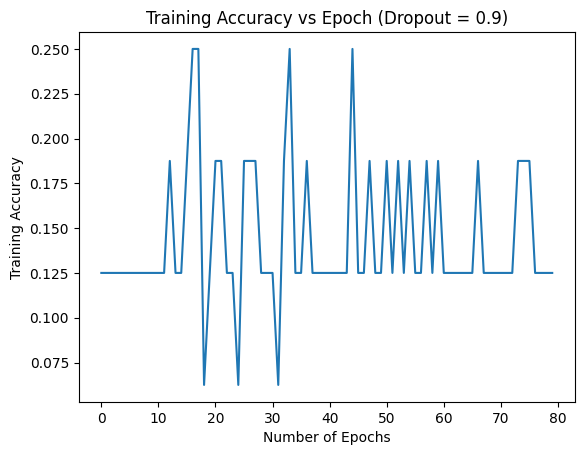

In [ ]:
## for graphing of training accuracy

import matplotlib.pyplot as plt

plt.plot(range(80), accuracy)
plt.title("Training Accuracy vs Epoch (Dropout = 0.9)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Training Loss')

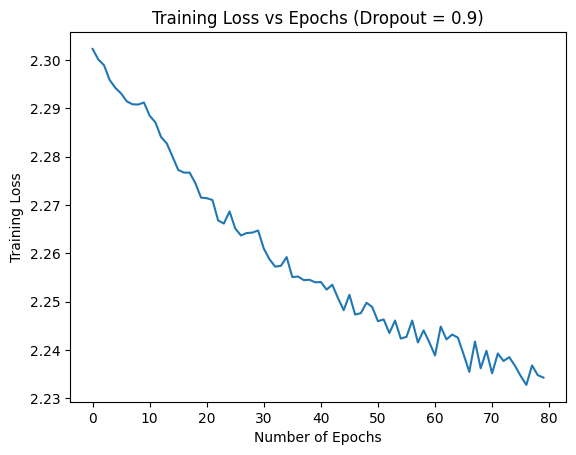

In [ ]:
## For graphing of training loss

plt.plot(range(80), train_loss)
plt.title("Training Loss vs Epochs (Dropout = 0.9)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")

In [ ]:
# For testing performance

from sklearn import metrics
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

y_pred = np.zeros(10000)

for i in range(0, len(test_x), 100):
      out = model(test_x[i:i+100,:,:,:])
      pred = np.argmax(out.cpu().detach().numpy(),1)
      y_pred[i:i+100] = pred

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
F1_score = f1_score(y_test, y_pred, average = "macro")
recall = recall_score(y_test, y_pred, average = "macro")
precision = precision_score(y_test, y_pred, average = "macro")
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[992,   0,   2,   1,   2,   3,   0,   0,   0,   0],
       [996,   0,   1,   2,   0,   1,   0,   0,   0,   0],
       [893,   0,  82,   4,  11,  10,   0,   0,   0,   0],
       [884,   0,   8,  79,   9,  20,   0,   0,   0,   0],
       [907,   0,   5,   8,  74,   6,   0,   0,   0,   0],
       [888,   0,   5,  17,  10,  78,   0,   0,   2,   0],
       [970,   0,   3,  12,   7,   8,   0,   0,   0,   0],
       [964,   0,   8,   9,  10,   9,   0,   0,   0,   0],
       [995,   0,   2,   0,   1,   2,   0,   0,   0,   0],
       [989,   0,   3,   5,   2,   1,   0,   0,   0,   0]])

In [ ]:
# Printing of testing performance

print("F1-Score:  ", F1_score)
print("Accuracy: ", accuracy)
print("Precision ", precision)
print("Recall ", recall)

F1-Score:   0.0743392043856593
Accuracy:  0.1305
Precision  0.25229003757280677
Recall  0.1305
